<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2Fourmethod/notebooks/Our_SBI_method_on_LV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet numpyro dm-haiku==0.0.5 optax

     |████████████████████████████████| 287 kB 9.9 MB/s 
     |████████████████████████████████| 140 kB 54.1 MB/s 
     |████████████████████████████████| 72 kB 563 kB/s 


In [ ]:
!pip install git+https://github.com/Justinezgh/SBI-Diff-Simulator.git@u/EiffL/numpyro

In [ ]:
!pip install chainconsumer

In [36]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

done.


In [3]:
%pylab inline
import arviz as az
az.style.use("arviz-darkgrid")

Populating the interactive namespace from numpy and matplotlib


In [29]:
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpyro
from numpyro.handlers import seed, trace, condition
from functools import partial

In [5]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [6]:
from sbids.tasks import lotka_volterra, get_samples_and_scores
from sbids.bijectors.bijectors import MixtureAffineSigmoidBijector

## Model with fixed latent variables

In [27]:
from numpyro.infer import MCMC, NUTS, Predictive
from chainconsumer import ChainConsumer

In [58]:
key = jax.random.PRNGKey(0)
lokta_volterra_10 = partial(lotka_volterra, ts=jnp.linspace(0,18.9,5))
lvcond = condition(lokta_volterra_10, {'z':jnp.array([30.0, 1.0])})
(log_probs, samples), scores = get_samples_and_scores(lvcond, key, batch_size=1)
observation = samples['y']
#observation = np.reshape(observation, (-1,10), order='F')
truth = samples['theta']

In [62]:
truth

DeviceArray([[0.603503  , 0.03026864, 1.6093055 , 0.01722082]], dtype=float32)

In [59]:
# use dense_mass for better mixing rate
mcmc = MCMC(
    NUTS(lokta_volterra_10, dense_mass=True,
init_strategy=numpyro.infer.initialization.init_to_sample),
    num_warmup=1000,
    num_samples=5000,
    num_chains=1,
    progress_bar=True,
)
mcmc.run(jax.random.PRNGKey(421), y=observation) 
mcmc.print_summary()

sample: 100%|██████████| 6000/6000 [26:03<00:00,  3.84it/s, 7 steps of size 4.92e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.59      0.04      0.58      0.51      0.65   3953.13      1.00
  theta[1]      0.03      0.00      0.03      0.02      0.03   4335.99      1.00
  theta[2]      1.65      0.10      1.65      1.49      1.81   4364.42      1.00
  theta[3]      0.02      0.00      0.02      0.02      0.02   4496.25      1.00
      z[0]     28.53      1.72     28.50     25.74     31.37   5227.55      1.00
      z[1]      1.08      0.08      1.08      0.95      1.21   5710.75      1.00

Number of divergences: 0


In [60]:
test_samples_fixed = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


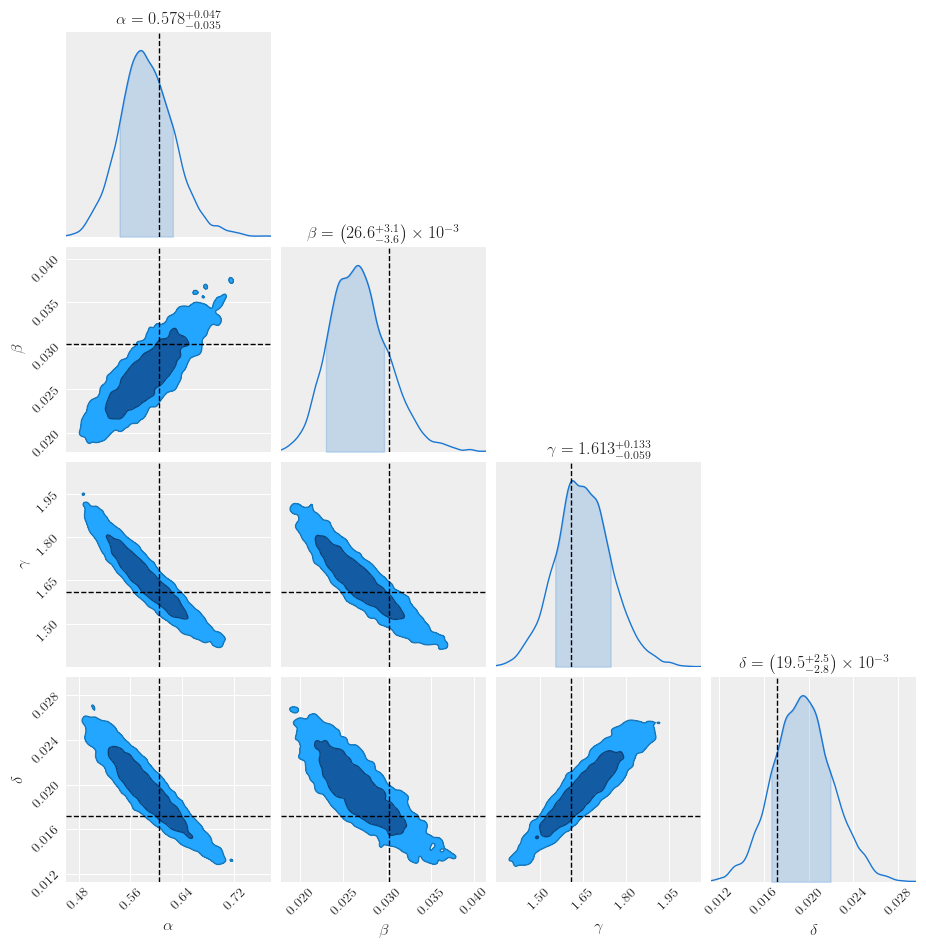

In [61]:
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(test_samples_fixed['theta'], parameters=parameters, name="HMC - free z")
fig = c.plotter.plot(figsize=[10,10], truth=[0.603503  , 0.03026864, 1.6093055 , 0.01722082])

## Data procees

In [63]:
key = jax.random.PRNGKey(30)
(log_probs, samples), scores = get_samples_and_scores(lokta_volterra_10, key, batch_size=1e4)
x1 = samples['y']
x = np.reshape(x1, (-1,10), order='F')
p = samples['theta']

In [64]:
if (x > 500).any() == True:
  idx = jnp.where(x > 500)[0]
  x = jnp.delete(x, idx, axis=0)
  p = jnp.delete(p, idx, axis=0)

if jnp.isnan(x).any() == True:
  idx = jnp.where(jnp.isnan(x))[0]
  x = jnp.delete(x, idx, axis=0)
  p = jnp.delete(p, idx, axis=0)

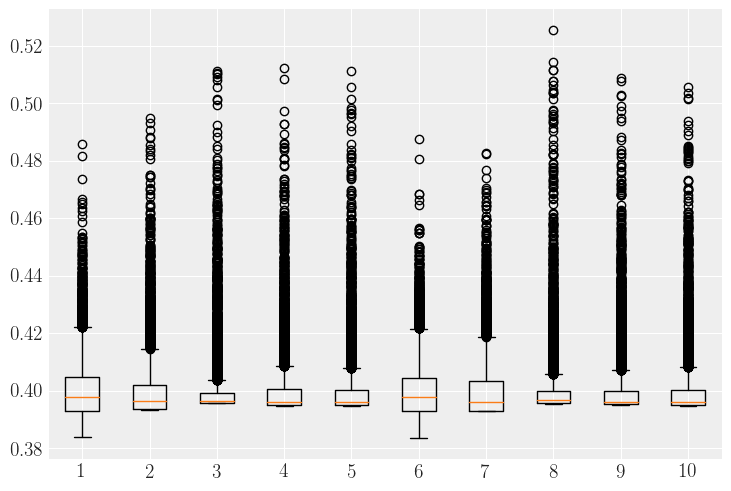

In [65]:
y=x
scale_reg = (jnp.std(y, axis =0)/0.01)
shift_reg = jnp.mean(y/scale_reg, axis = 0)-0.4

normalized_reg = (y/scale_reg) - shift_reg

data = [normalized_reg[...,0],
        normalized_reg[...,1],
        normalized_reg[...,2],
        normalized_reg[...,3],
        normalized_reg[...,4],
        normalized_reg[...,5],
        normalized_reg[...,6],
        normalized_reg[...,7],
        normalized_reg[...,8],
        normalized_reg[...,9],]

plt.boxplot(data);

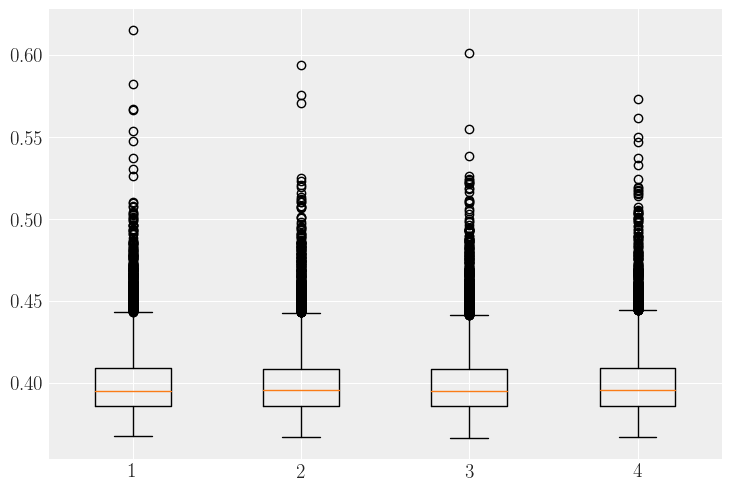

In [66]:
scale_theta = (jnp.std(p, axis =0)/0.02)
shift_theta = jnp.mean(p/scale_theta, axis = 0)-0.4

normalized_p = (p/scale_theta) - shift_theta
data = [normalized_p[...,0],normalized_p[...,1],normalized_p[...,2],normalized_p[...,3]]
plt.boxplot(data);

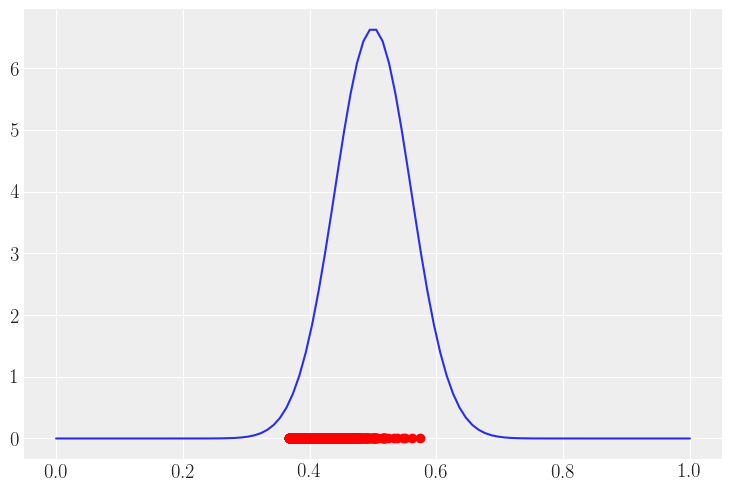

In [67]:
dist = tfd.Normal(0.5*jnp.ones(1), scale=0.06)
xaxe = jnp.linspace(0,1,100)
plt.plot(xaxe,dist.prob(xaxe))
plt.scatter(normalized_p[...,3],jnp.zeros(len(x)), color = 'r')

## NF

In [68]:
d = 4

class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __init__(self, y, *args, **kwargs):
    self.y = y
    super(CustomCoupling, self).__init__(*args, **kwargs)

  def __call__(self, x, output_units, **condition_kwargs):
   
    net = jnp.concatenate([x, ((self.y/scale_reg) - shift_reg)], axis=-1)

    net = hk.Linear(32, name='l1')(net)
    net = jax.nn.silu(net) 
    net = hk.Linear(64, name='l2')(net)
    net = jax.nn.silu(net) 
    net = hk.Linear(256, name='l6')(net)
    net = jax.nn.silu(net)
    net = hk.Linear(128, name='l7')(net)
    net = jax.nn.silu(net)
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    n_components = 32
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_components, name='l3')(net)) * log_a_bound
    b   = hk.Linear(output_units*n_components, name='l4')(net)
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_components, name='l5')(net)) * (1 - min_density_lower_bound)
    p   = hk.Linear(output_units*n_components, name='l6')(net)

    log_a = log_a.reshape(-1,output_units,n_components)
    b = b.reshape(-1,output_units,n_components)
    c = c.reshape(-1,output_units,n_components)
    p = p.reshape(-1,output_units,n_components)
    p = jax.nn.softmax(p)


    return MixtureAffineSigmoidBijector(jnp.exp(log_a),b,c,p)

class Flow_nd(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self, y):
    #def __call__(self):
      chain = tfb.Chain([
            tfb.Scale(scale = scale_theta, name='scale1'),
            tfb.Shift(shift = shift_theta, name = 'shift1'),
            tfb.RealNVP(2, bijector_fn=CustomCoupling(y, name = 'b1')),
            tfb.Permute([3,2,1,0]),
            tfb.RealNVP(2, bijector_fn=CustomCoupling(y, name = 'b2')),
            tfb.Permute([3,2,1,0]),
            tfb.RealNVP(2, bijector_fn=CustomCoupling(y, name = 'b3')),           
            tfb.Permute([3,2,1,0]),
            tfb.RealNVP(2, bijector_fn=CustomCoupling(y, name = 'b4')),           
            tfb.Permute([3,2,1,0]),
            tfb.RealNVP(2, bijector_fn=CustomCoupling(y, name = 'b5')),           
            tfb.Permute([3,2,1,0]),
            tfb.RealNVP(2, bijector_fn=CustomCoupling(y, name = 'b6')),           
            #tfb.Permute([3,2,1,0]),
            #tfb.RealNVP(2, bijector_fn=CustomCoupling(y, name = 'b7')),           
            #tfb.Permute([3,2,1,0]),
            #tfb.RealNVP(2, bijector_fn=CustomCoupling(y, name = 'b8')),           
            tfb.Permute([3,2,1,0]),


        ])
      
      nvp = tfd.TransformedDistribution(
           tfd.MultivariateNormalDiag(0.5*jnp.ones(d), scale_identity_multiplier=0.06),
            bijector=chain)
      
      return nvp

In [69]:
from tqdm import tqdm

In [70]:
def loss_fn(params, weight, mu, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,4]), x.reshape([1,10])).squeeze()))(mu, batch)
  return -jnp.mean(log_prob) + weight * jnp.mean(jnp.sum((out - score)**2, axis=1)) 


@jax.jit
def update(params, opt_state, weight, mu, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, weight, mu, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [71]:
nvp_nd = hk.without_apply_rng(hk.transform(lambda p,x : Flow_nd()(x).log_prob(p).squeeze()))

In [ ]:
rng_seq = hk.PRNGSequence(5)
params_nd = nvp_nd.init(next(rng_seq),  0.4*jnp.ones([1,4]), 0.4*jnp.ones([1,10]))
scheduler = optax.exponential_decay(init_value=0.001, transition_steps=2000, decay_rate=0.9, end_value=0.00001)
optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
opt_state = optimizer.init(params_nd)

In [73]:
key = jax.random.PRNGKey(10)
(log_probs, samples), score = get_samples_and_scores(lokta_volterra_10, key, batch_size=5e5)
batch = samples['y']
batch = np.reshape(batch, (-1,10), order='F')
mu = samples['theta']


if (batch > 500).any() == True:
  idx = jnp.where(batch > 500)[0]
  batch = jnp.delete(batch, idx, axis=0)
  mu = jnp.delete(mu, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)

if jnp.isnan(batch).any() == True:
  idx = jnp.where(jnp.isnan(batch))[0]
  batch = jnp.delete(batch, idx, axis=0)
  mu = jnp.delete(mu, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)

In [74]:
  batch_size = 1000
  ntrain = len(batch)
  num_batches = ntrain // batch_size 
  def data_stream():
      """
      Creates a data stream with a predifined batch size.
      """
      rng = np.random.RandomState(0)
      while True:
        perm = rng.permutation(ntrain)
        for i in range(num_batches):
          batch_idx = perm[i * batch_size: (i + 1)*batch_size]
          yield batch[batch_idx], mu[batch_idx], score[batch_idx]

  batches = data_stream()

In [ ]:
  #losses = []
  num_epochs = 30
  weight = 0 
  epochs = 0
  
  while epochs < num_epochs: 
    for _ in tqdm(range(num_batches)):
      b,m,s = next(batches)    
      l, params_nd, opt_state = update(params_nd, opt_state,weight, m,  b, s)
      losses.append(l)
      

      if jnp.isnan(l)==True:
        print('NAN')
        break

      params_nd_t = params_nd

    if jnp.isnan(l)==True:
      print('NAN')
      break    
    
      
    epochs +=1

 75%|███████▌  | 372/496 [00:18<00:06, 20.30it/s]

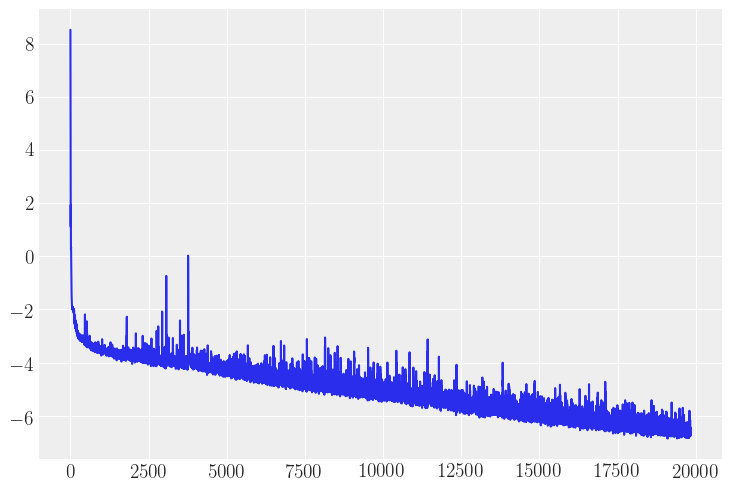

In [87]:
plt.plot(losses)

In [79]:
observation = np.reshape(observation, (-1,10), order='F')

In [ ]:
nvp_sample_nd = hk.transform(lambda x : Flow_nd()(x).sample(1e4, seed=hk.next_rng_key()))
sample_nd = nvp_sample_nd.apply(params_nd, rng = next(rng_seq), x = observation*jnp.ones([int(1e4),10]))

In [56]:
truth

DeviceArray([[0.603503  , 0.03026864, 1.6093055 , 0.01722082]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


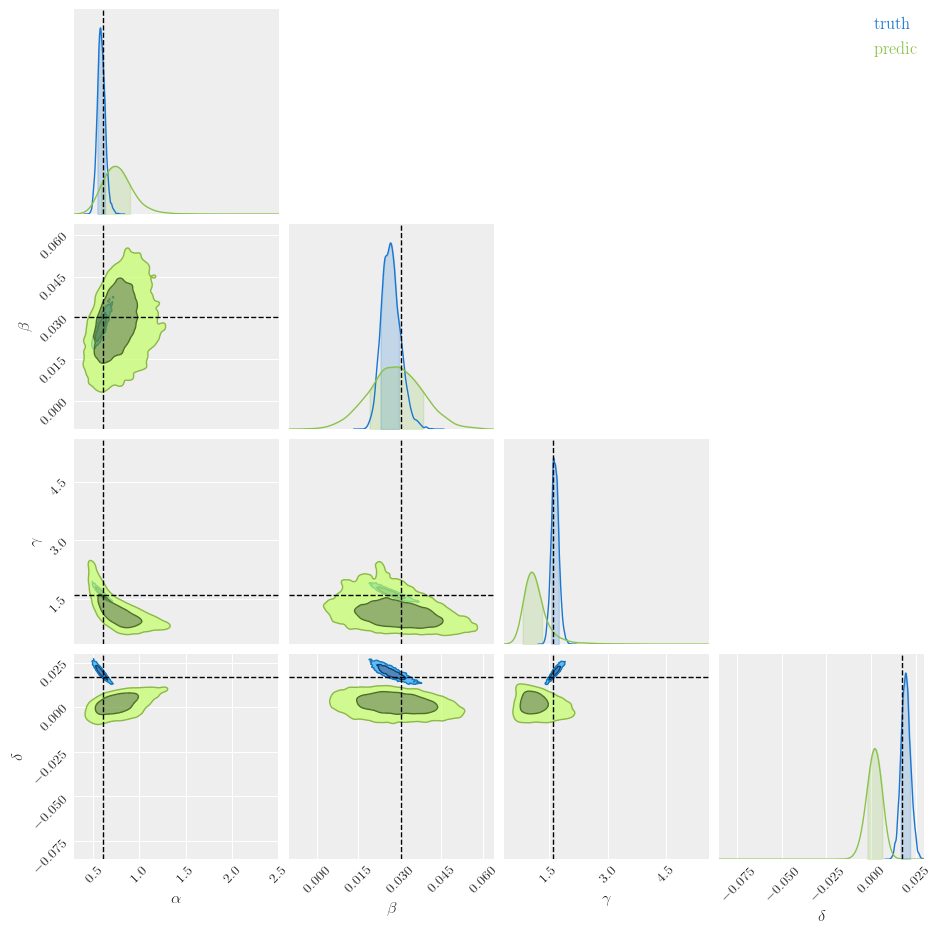

In [89]:
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(test_samples_fixed['theta'], parameters=parameters, name="truth")
c.add_chain(sample_nd, parameters=parameters, name="predic")
fig = c.plotter.plot(figsize=[10,10], truth=[0.603503  , 0.03026864, 1.6093055 , 0.01722082])